In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datacompy
import os, sys
import numpy as np
import re
import ast

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV,
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, accuracy_score
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy import stats
from joblib import dump, load

# modele
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# methods
from imblearn.under_sampling import ClusterCentroids, NearMiss
from scipy.optimize import differential_evolution
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.inspection import permutation_importance
from scipy.spatial.distance import euclidean
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
#from ctgan import CTGAN

Please note that you are missing the optional dependency: fugue. If you need to use this functionality it must be installed.
Please note that you are missing the optional dependency: spark. If you need to use this functionality it must be installed.
Please note that you are missing the optional dependency: snowflake. If you need to use this functionality it must be installed.
C:\Users\mateuszd\AppData\Local\Temp\ipykernel_14624\1082524922.py:5: UserWarning: SparkPandasCompare currently only supports Numpy < 2.Please note that the SparkPandasCompare functionality will not work and currently is not supported.
  import datacompy


## Data

### Read data

In [2]:
#oversampling data
original_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\original_data.csv")    
original_data = original_data.drop(columns=["Unnamed: 0"])
smote_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\smote_data.csv")
GAN_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\GAN_data.csv")
borderline_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\borderline_data.csv")
smote2_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\smote3_data.csv")
GAN2_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\GAN3_data.csv")    
borderline2_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\borderline3_data.csv")

# test data
X_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\test\\X_test.csv")
y_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\test\\y_test.csv")


""" #undersampling prepare data //mixed data (gan, brdsmote, smote)
cc_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\clustercentroids_data.csv")
if_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\isolationforest_data.csv")
nm_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\nearmiss_data.csv")
median_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\median_data.csv")
lof_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\localoutlierfactor_data.csv") """


' #undersampling prepare data //mixed data (gan, brdsmote, smote)\ncc_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\clustercentroids_data.csv")\nif_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\isolationforest_data.csv")\nnm_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\nearmiss_data.csv")\nmedian_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\median_data.csv")\nlof_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\localoutlierfactor_data.csv") '

In [4]:
print(original_data["target"].value_counts())
count1=original_data["target"].value_counts().sum()
print(count1)
count2=abs((original_data['target']==0).sum() - (original_data['target']==1).sum())
print(f"Before undersampling: {count2}")
print(f"After number of samples: {count1+count2}")

target
0    151
1     46
Name: count, dtype: int64
197
Before undersampling: 105
After number of samples: 302


### Preprocessing Data

In [5]:
#mixed data
mix_data = pd.concat([GAN_data, smote_data, borderline_data, original_data], axis=0, ignore_index=True)         
mix_data = mix_data.reset_index(drop=True)

#data with one oversampling method and original data e.g.(smote+original)
smote_data = pd.concat([smote_data, smote2_data, original_data], axis=0, ignore_index=True)
smote_data = smote_data.reset_index(drop=True)
borderline_data = pd.concat([borderline_data, borderline2_data, original_data], axis=0, ignore_index=True)
borderline_data = borderline_data.reset_index(drop=True)
GAN_data = pd.concat([GAN_data, GAN2_data, original_data], axis=0, ignore_index=True)
GAN_data = GAN_data.reset_index(drop=True)

sum_all_data = pd.concat([smote_data, GAN_data, borderline_data, original_data], axis=0, ignore_index=True)
sum_all_data = sum_all_data.drop_duplicates()

#### Split data

In [8]:
X_mix, y_mix = mix_data.drop(columns=["target", "source"]), mix_data["target"]
X_smote, y_smote = smote_data.drop(columns=["target", "source"]), smote_data["target"]
X_GAN, y_GAN = GAN_data.drop(columns=["target", "source"]), GAN_data["target"]
X_borderline, y_borderline = borderline_data.drop(columns=["target", "source"]), borderline_data["target"]

#### Dictionary

In [9]:
data = {}
data["mix"] = (X_mix, y_mix)
data["smote"] = (X_smote, y_smote)
data["GAN"] = (X_GAN, y_GAN)
data["borderline"] = (X_borderline, y_borderline)

compare = {}
compare["mix"] = mix_data
compare["smote"] = smote_data
compare["GAN"] = GAN_data
compare["borderline"] = borderline_data

## Undersampling

### NearMiss version1

In [ ]:
NM = NearMiss(version=1)

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
    
    X_NM, y_NM = NM.fit_resample(X_train, y_train)
    
    #concat resampled data
    nearmiss_data = pd.concat([X_NM, y_NM], axis=1)
    
    NM_data_nosource = compare_df.drop(columns=["source"])
    nearmiss_data_nosource = nearmiss_data

    for index, row in nearmiss_data_nosource.iterrows():
        match = NM_data_nosource.eq(row).all(axis=1)  # Sprawdza, gdzie wiersze są identyczne
        if match.any():  # Jeśli znaleziono dopasowanie
            matched_index = match.idxmax()  # Pobiera pierwszy pasujący indeks
            nearmiss_data.loc[index, "source"] = compare_df.loc[matched_index, "source"]
            
    nearmiss_data.to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_NM_data.csv")
    
    print(f"Data reduced for {name} data")
    print(nearmiss_data["target"].value_counts())
    

### K-means

In [ ]:
KM = KMeans(n_clusters=(int)((count1+count2)/2))

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
    
    X_majority = X_train[y_train == 1]
    X_minority = X_train[y_train == 0]
    
    kmeans = KM.fit(X_majority)
    
    X_majority_reduced = pd.DataFrame(kmeans.cluster_centers_, columns=X_train.columns)
    y_majority_reduced = pd.Series([1] * (int)((count1+count2)/2), name="target") 
    
    X_minority = X_minority.reset_index(drop=True)
    y_minority = pd.Series([0] * len(X_minority), name="target")
    
    X_final = pd.concat([X_majority_reduced, X_minority], axis=0).reset_index(drop=True) 
    y_final = pd.concat([y_majority_reduced, y_minority], axis=0).reset_index(drop=True)
    
    # Concat resampled data
    reduced_data = pd.concat([X_final, y_final], axis=1)
    
    reduced_data["source"] = None  # Initialize the source column with None
    
    # gdy target = 1 wtedy source = "centroid", inaczej source = "original"
    
    # Compare data to copy source column
    data_nosource = compare_df
    reduced_data_nosource = reduced_data

    # Iterate through the rows in reduced_data_nosource
    for index, row in reduced_data_nosource.iterrows():
        match = data_nosource.eq(row).all(axis=1)  # Check where rows are identical
        if match.any():  # If a match is found
            matched_index = match.idxmax()  # Get the first matching index
            reduced_data.loc[index, "source"] = compare_df.loc[matched_index, "source"]
            
    # Check for any rows that still have None in the source column
    missing_source = reduced_data[reduced_data["source"].isna()]
    if not missing_source.empty:
        reduced_data.loc[reduced_data["source"].isna(), "source"] = "centroid"       
    
    #reduced_data.to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_KM_data.csv", index=False)
    
    print(f"Data reduced for {name} data")
    print(reduced_data["target"].value_counts())

c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for mix data
target
1    151
0    151
Name: count, dtype: int64


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for smote data
target
1    151
0    151
Name: count, dtype: int64


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for GAN data
target
1    151
0    151
Name: count, dtype: int64


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Data reduced for borderline data
target
1    151
0    151
Name: count, dtype: int64


### K-means-SWAP (centroid is swap on the nearest sample)

In [16]:
KM = KMeans(n_clusters=(int)((count1+count2)/2))

centroids_rows_ = {
    "mix": {},
    "smote": {},
    "GAN": {},
    "borderline": {}
}

centroids_ = {}

results_KM_SWAP_ = {
    "mix": {},
    "smote": {},
    "GAN": {},
    "borderline": {}
}

results_ = {}
df_ = {}

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
     # klasteryzacja dotyczy tylko jednego ze zbiorow drugi jest przepisywany
    X_majority = X_train[y_train == 1]
    X_minority = X_train[y_train == 0]
    
    kmeans = KM.fit(X_majority)
    
    #centroids
    for i in range ((int)((count1+count2)/2)):
        rows_in_cluster = X_majority[kmeans.labels_ == i] 
        centroids_rows_[name][i] = rows_in_cluster
        
        centroids_ = pd.DataFrame(kmeans.cluster_centers_, columns=X_train.columns)
    
    #results_KM_SWAP_ = {}
    
    
    for i in range(len(centroids_)):
        if (len(centroids_rows_[name][i])>1):
            dist_={}
            index_ = {}
            centroid = centroids_.iloc[i]
            for j in range(len(centroids_rows_[name][i])):
                index_ = list(centroids_rows_[name][i].index)
                row = centroids_rows_[name][i].iloc[j]
                #index_ = { "index_rows": j, "index_centroid": list(centroids_rows_[name][i].index) } #tworze slwonik wartosci
                index_map = {j: idx for j, idx in enumerate(index_)}
                
                #print(index_)
                dist_[j] = euclidean(centroid, row)         #tworze slwonik wartosci
                
            #print(index_map)    
            min_key = min(dist_, key=dist_.get)
            #print(min_key)
            #new_cent = index_.get
            results_KM_SWAP_[name][i] = centroids_rows_[name][i].iloc[[min_key]]
            
            #print(results_KM_SWAP_[i])
            
            #results_KM_SWAP_[i] = dist_.iloc[min_index]
            #print(dist_[0])
        else:
            results_KM_SWAP_[name][i] = centroids_rows_[name][i].iloc[[0]]
        
        results_[name] = pd.concat(results_KM_SWAP_[name].values(), ignore_index=True)    
        #results_KM_SWAP_[name][i]["target"] = 1      
        #results_KM_SWAP_[name][i]["source"] = None
        #print(results_KM_SWAP_[name])    
    
    
    """ for key in ["mix", "smote", "GAN", "borderline"]:
        df_[name] = pd.DataFrame.from_dict(results_KM_SWAP_[name], orient="index")        """   

    
        
    df_y_majority = pd.Series([1] * (int)((count1+count2)/2), name="target") 
    df_majority = pd.concat([results_[name], df_y_majority], axis=1).reset_index(drop=True)
        
    print(df_majority)        
    df_X_minority = X_minority.reset_index(drop=True)
    df_y_minority = pd.Series([0] * len(X_minority), name="target")
    df_miniority = pd.concat([df_X_minority, df_y_minority], axis=1).reset_index(drop=True)
    print(df_miniority)
        #print(df_[name])
    df_[name] = pd.concat([df_majority, df_miniority], axis=0).reset_index(drop=True)  
    
    #copy source from sum_all_data 
    columns_ = list(df_[name].columns.values)
    df_[name] = df_[name].merge(sum_all_data, on=columns_, how="left")
    print(df_[name])  
    
    df_[name].to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_KM_SWAP_data.csv", index=False)

c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


     user  is_private  is_failure  is_root  is_valid  not_valid_count  \
0      13           1           1        0         0                0   
1      36           1           1        0         0                2   
2      21           1           1        0         0                1   
3       3           1           1        1         1                0   
4      13           0           1        1         0                3   
..    ...         ...         ...      ...       ...              ...   
146    29           1           1        1         0               10   
147    43           0           1        0         0                7   
148     0           0           1        0         0                1   
149    26           1           1        0         0                0   
150    17           1           1        0         0                9   

     ip_failure  ip_success  no_failure  first    td        ts  target  
0             4           1           9      0    

c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


     user  is_private  is_failure  is_root  is_valid  not_valid_count  \
0       2           1           1        0         0               16   
1      27           1           1        0         0                9   
2      21           1           1        0         0                1   
3      37           0           1        1         1                0   
4      31           1           1        0         0               11   
..    ...         ...         ...      ...       ...              ...   
146    37           0           1        1         1                0   
147     5           1           1        0         0                5   
148    32           0           1        0         1                0   
149     5           1           1        0         0                0   
150    33           1           1        0         0               20   

     ip_failure  ip_success  no_failure  first    td        ts  target  
0            16           0          16      0    

c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


     user  is_private  is_failure  is_root  is_valid  not_valid_count  \
0      42           1           1        0         1               11   
1       7           1           1        0         0               19   
2      18           0           1        0         1               21   
3      35           0           1        1         0               17   
4       4           1           1        1         0               13   
..    ...         ...         ...      ...       ...              ...   
146    28           1           1        1         0                0   
147    27           1           1        0         0                4   
148    23           1           1        0         1                2   
149     7           1           1        0         1                9   
150    13           0           1        0         1               15   

     ip_failure  ip_success  no_failure  first    td        ts  target  
0            23           0          15      0    

c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


     user  is_private  is_failure  is_root  is_valid  not_valid_count  \
0      29           1           1        0         1                0   
1      34           1           1        0         0                1   
2      35           1           1        0         0                3   
3      32           1           1        0         0                9   
4      37           1           1        1         1                0   
..    ...         ...         ...      ...       ...              ...   
146    10           1           1        0         0                1   
147     0           1           1        0         0               11   
148    34           0           1        0         1                0   
149     3           1           1        0         0               17   
150    31           0           1        1         1                0   

     ip_failure  ip_success  no_failure  first    td        ts  target  
0             8           0          12      0    

### ClusterCentroids

In [ ]:
CC = ClusterCentroids(sampling_strategy="majority", voting="auto")

for (name, (X_train, y_train)), (_, compare_df) in zip(data.items(), compare.items()):
    
    X_CC, y_CC = CC.fit_resample(X_train, y_train)
    
    # Concat resampled data
    reduced_data = pd.concat([X_CC, y_CC], axis=1)
    
    # Compare data to copy source column
    data_nosource = compare_df.drop(columns=["source"])
    reduced_data_nosource = reduced_data.drop(columns=["source"], errors='ignore')

    reduced_data["source"] = None  # Initialize the source column with None

    # Iterate through the rows in reduced_data_nosource
    for index, row in reduced_data_nosource.iterrows():
        match = data_nosource.eq(row).all(axis=1)  # Check where rows are identical
        if match.any():  # If a match is found
            matched_index = match.idxmax()  # Get the first matching index
            reduced_data.loc[index, "source"] = compare_df.loc[matched_index, "source"]
    
    # Check for any rows that still have None in the source column
    missing_source = reduced_data[reduced_data["source"].isna()]
    if not missing_source.empty:
        reduced_data.loc[reduced_data["source"].isna(), "source"] = "centroid"
    
    reduced_data.to_csv(f"D:\\ml\\undersampling_data\\data\\ssh\\reduced\\{name}_CC_data.csv", index=False)
    
    print(f"Data reduced for {name} data")
    print(reduced_data["target"].value_counts())

## Learning

### Data after reduced

In [ ]:
#NearMiss reduced data
mix_NM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\mix_NM_data.csv")
smote_NM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\smote_NM_data.csv")
GAN_NM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\GAN_NM_data.csv")
borderline_NM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\borderline_NM_data.csv")

#KMeans reduced data
mix_KM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\mix_KM_data.csv")          
smote_KM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\smote_KM_data.csv")
GAN_KM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\GAN_KM_data.csv")
borderline_KM_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\borderline_KM_data.csv")

#ClusterCentroids reduced data
mix_CC_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\mix_CC_data.csv")
smote_CC_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\smote_CC_data.csv")
GAN_CC_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\GAN_CC_data.csv")
borderline_CC_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\borderline_CC_data.csv")

#KMeans with SWAP->NN reduced data
mix_KM_SWAP_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\mix_KM_SWAP_data.csv")
smote_KM_SWAP_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\smote_KM_SWAP_data.csv")
GAN_KM_SWAP_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\GAN_KM_SWAP_data.csv")
borderline_KM_SWAP_data = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\reduced\\borderline_KM_SWAP_data.csv")

X_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\test\\X_test.csv")
y_test = pd.read_csv("D:\\ml\\undersampling_data\\data\\ssh\\test\\y_test.csv")

In [ ]:
# Lista wszystkich zbiorów danych
all_reduced_datasets = [
    mix_NM_data, smote_NM_data, GAN_NM_data, borderline_NM_data,
    mix_KM_data, smote_KM_data, GAN_KM_data, borderline_KM_data,
    mix_KM_SWAP_data, smote_KM_SWAP_data, GAN_KM_SWAP_data, borderline_KM_SWAP_data,
    mix_CC_data, smote_CC_data, GAN_CC_data, borderline_CC_data, 
    X_test, y_test
]

# Usuń kolumnę 'Unnamed: 0' jeśli istnieje
for i, df in enumerate(all_reduced_datasets):
    if 'Unnamed: 0' in df.columns:
        all_reduced_datasets[i] = df.drop(columns=['Unnamed: 0'])

# Przypisz z powrotem do zmiennych (jeśli chcesz dalej używać tych samych nazw)
(
    mix_NM_data, smote_NM_data, GAN_NM_data, borderline_NM_data,
    mix_KM_data, smote_KM_data, GAN_KM_data, borderline_KM_data,
    mix_KM_SWAP_data, smote_KM_SWAP_data, GAN_KM_SWAP_data, borderline_KM_SWAP_data,
    mix_CC_data, smote_CC_data, GAN_CC_data, borderline_CC_data, X_test, y_test
) = all_reduced_datasets

In [ ]:
data = {
    "mix_NM": mix_NM_data,
    "smote_NM": smote_NM_data,
    "GAN_NM": GAN_NM_data,
    "borderline_NM": borderline_NM_data,
    "mix_KM": mix_KM_data,
    "smote_KM": smote_KM_data,
    "GAN_KM": GAN_KM_data,
    "borderline_KM": borderline_KM_data,
    "mix_KM_SWAP": mix_KM_SWAP_data,
    "smote_KM_SWAP": smote_KM_SWAP_data,
    "GAN_KM_SWAP": GAN_KM_SWAP_data,
    "borderline_KM_SWAP": borderline_KM_SWAP_data,
    "mix_CC": mix_CC_data,
    "smote_CC": smote_CC_data,
    "GAN_CC": GAN_CC_data,
    "borderline_CC": borderline_CC_data
}

#split data
X_train_ = {}
y_train_ = {}

for name in data:
    X_train_[name] = data[name].drop(columns=["target", "source"])
    y_train_[name] = data[name]["target"]

#define models    
model_classes = {
    "LR": LogisticRegression,
    "DT": DecisionTreeClassifier,
    "RF": RandomForestClassifier,
    "XGB": XGBClassifier,
    "XGBRF": XGBRFClassifier
}

#define data variants
data_variants = [
    "mix_NM", "smote_NM", "GAN_NM", "borderline_NM",
    "mix_KM", "smote_KM", "GAN_KM", "borderline_KM",
    "mix_KM_SWAP", "smote_KM_SWAP", "GAN_KM_SWAP", "borderline_KM_SWAP",
    "mix_CC", "smote_CC", "GAN_CC", "borderline_CC"
]

models = {}

for model_name, model_class in model_classes.items():
    for variant in data_variants:
        key = f"{model_name}_{variant}"
        models[key] = model_class()
        
training_data = {}

for model_key in models.keys():
    if "_" in model_key:
        base_model_name = model_key.split("_")[0]
    else:
        base_model_name = model_key

    for data_key in data.keys():
        full_key = f"{base_model_name}_{data_key}" if data_key else base_model_name
        training_data[full_key] = (X_train_[data_key], y_train_[data_key])

### GridSearch

In [ ]:
params_ = {
    "LR": {
        'max_iter': [100, 500, 1000],
        'random_state': [0, 10, 20, 30, 40]
    },
    "DT": {
        'max_depth': [4, 8, 12, 16],
        'random_state': [0, 10, 20, 30, 40],
        'min_samples_leaf': [1, 2]
    },
    "RF": {
        'n_estimators': [20, 40, 60, 80, 100],
        'max_depth': [4, 8, 12, 16],
        'min_samples_leaf': [1, 2],
        'random_state': [0, 10, 20, 30, 40]
    },
    "XGB": {
        'max_depth': [4, 8, 12, 16],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
    },
    "XGBRF": {
        'max_depth': [4, 8, 12, 16],
        'n_estimators': [20, 40, 60, 80, 100],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
        'random_state': [0, 10, 20, 30, 40]
    }
}

goal = ['accuracy','precision', 'recall', 'f1'] 
file_pathes = ["D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\accuracy.txt"
                ,"D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\precision.txt"
               ,"D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\recall.txt"
               ,"D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\f1.txt"]

best_prams = {}

for score_1, file_path in zip(goal, file_pathes):
    for model_key, data_key in zip(models.keys(), training_data.keys()):
        model = models[model_key]
        data = training_data[data_key]
        
        param_grid = None
        for key in params_.keys():
            if model_key.startswith(key):
                param_grid = params_[key]
                break
        
        if param_grid is not None:
            grid_search = GridSearchCV(model, param_grid=param_grid, scoring=score_1, n_jobs=1).fit(data[0], data[1])
            print(f"{score_1} & {model_key}")
            with open(file_path, "a+") as f:
                print(f'scoring: {score_1}', file=f)
                print(f'Best parameters for {score_1} & {model_key}:', grid_search.best_params_, file=f)
                print(f'Best score for {score_1} & {model_key}:', grid_search.best_score_, file=f)
                
            best_prams[f"{model_key}_{score_1}"] = grid_search.best_estimator_

### Learning Models Cross-Vali

In [ ]:
# Function to extract parameters from text file
def extract_params_from_file(file_path):
    params = {}
    with open(file_path, 'r') as file:
        content = file.read()

    # Lepszy regex z zabezpieczeniem końca
    matches = re.findall(
        r'Best parameters for accuracy & ([\w_]+):\s*({.*?})(?:\nBest score|\Z)',
        content,
        re.DOTALL
    )

    for match in matches:
        key, param_str = match
        try:
            param_dict = ast.literal_eval(param_str)
            params[key] = param_dict
        except Exception as e:
            print(f"[!] Error parsing params for {key}: {e}")

    return params

# Extract parameters from text files
accuracy_params = extract_params_from_file("D:\\ml\\undersampling_data\\reports\\ssh\\grid_search\\old\\accuracy.txt")

# Update the models dictionary with the best models
models = {key: model_classes[key.split('_')[0]]().set_params(**params) for key, params in accuracy_params.items()}

# Display the resulting models dictionary
for key, model in models.items():
    print(f"Training {key}: {model}")
    

In [29]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
results_cross_mean_under=[]
results_cross_std_under=[]
goal = ['accuracy', 'precision','f1','recall']
path_files = ["D:\\ml\\undersampling_data\\reports\\ssh\\results\\accuracy_metrics2.txt",
              "D:\\ml\\undersampling_data\\reports\\ssh\\results\\precision_metrics2.txt", 
              "D:\\ml\\undersampling_data\\reports\\ssh\\results\\f1_metrics2.txt", 
              "D:\\ml\\undersampling_data\\reports\\ssh\\results\\recall_metrics2.txt"]

excel_file_cross = "D:\\ml\\undersampling_data\\reports\\ssh\\results\\cross2.xlsx"
excel_file_cross2 = "D:\\ml\\undersampling_data\\reports\\ssh\\results\\cross_std2.xlsx"
name_sheet1 = "Arkusz1"

model_scores = {}

for metrix1, path_file in zip(goal, path_files):
    for model_key, data_key in zip(models.keys(), training_data.keys()):
        model = models[model_key]
        X_train, y_train = training_data[model_key]
        cross_val_results = cross_val_score(model, X_train, y_train, cv=cv, scoring=metrix1, n_jobs=1)
        print(f"Learn: {metrix1} and model {model_key}")
        with open(path_file, "a+") as f:
            # Zapis wyników do pliku
            print(f'{model_key} Cross-Validation Results {metrix1}:\n {cross_val_results}', file=f)
            print(f'Mean {metrix1}: {cross_val_results.mean()}', file=f)
            print(f'Dev: {cross_val_results.std()}', file=f)
            print("\n", file=f)
        
        results_cross_mean_under.append({
        "Model": model_key,
        "Metric": metrix1,
        "Result": cross_val_results.mean()})
        results_cross_std_under.append({
        "Model": model_key,
        "Metric": metrix1,
        "Std": cross_val_results.std()})
        df_results_cross_under_mean = pd.DataFrame(results_cross_mean_under)
        df_results_cross_under_std = pd.DataFrame(results_cross_std_under)
        df_save_under_mean = df_results_cross_under_mean.pivot(index="Metric", columns="Model", values="Result")
        df_save_under_std = df_results_cross_under_std.pivot(index="Metric", columns="Model", values="Std")
        
"""        with pd.ExcelFile(excel_file_cross) as w:
            df_save_under_mean.to_excel(w, sheet_name=name_sheet1)
        with pd.ExcelFile(excel_file_cross2) as w1:
            df_save_under_std.to_excel(w1, sheet_name=name_sheet1) """


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Learn: accuracy and model LR_mix_NM


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Learn: accuracy and model LR_smote_NM


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Learn: accuracy and model LR_GAN_NM


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Learn: accuracy and model LR_borderline_NM


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Learn: accuracy and model LR_mix_KM


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Learn: accuracy and model LR_smote_KM


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Learn: accuracy and model LR_GAN_KM


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Learn: accuracy and model LR_borderline_KM


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Learn: accuracy and model LR_mix_CC


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Learn: accuracy and model LR_smote_CC


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Learn: accuracy and model LR_GAN_CC


c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mateuszd\anaconda3\envs\python10\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Learn: accuracy and model LR_borderline_CC
Learn: accuracy and model DT_mix_NM
Learn: accuracy and model DT_smote_NM
Learn: accuracy and model DT_GAN_NM
Learn: accuracy and model DT_borderline_NM
Learn: accuracy and model DT_mix_KM
Learn: accuracy and model DT_smote_KM
Learn: accuracy and model DT_GAN_KM
Learn: accuracy and model DT_borderline_KM
Learn: accuracy and model DT_mix_CC
Learn: accuracy and model DT_smote_CC
Learn: accuracy and model DT_GAN_CC
Learn: accuracy and model DT_borderline_CC
Learn: accuracy and model RF_mix_NM
Learn: accuracy and model RF_smote_NM
Learn: accuracy and model RF_GAN_NM
Learn: accuracy and model RF_borderline_NM
Learn: accuracy and model RF_mix_KM
Learn: accuracy and model RF_smote_KM
Learn: accuracy and model RF_GAN_KM
Learn: accuracy and model RF_borderline_KM
Learn: accuracy and model RF_mix_CC
Learn: accuracy and model RF_smote_CC
Learn: accuracy and model RF_GAN_CC
Learn: accuracy and model RF_borderline_CC


AttributeError: 'super' object has no attribute '__sklearn_tags__'

### Save Models + Create Figures

In [ ]:
for model_name, model in models.items():  
    name = f"D:\\ml\\undersampling_data\\models\\ssh\\{model_name}.joblib"  
    dump(model, name)
    print(f"Model {model_name} saved in: {name}")

In [46]:
# test data prepare
test_data = pd.concat([X_test, y_test], axis=1)
class_0_samples = test_data[test_data['target'] == 0].sample(n=20, random_state=42)
class_1_samples = test_data[test_data['target'] == 1].sample(n=20, random_state=42)

balanced_test_data = pd.concat([class_0_samples, class_1_samples])

X_test = balanced_test_data.drop(columns=['target'])
y_test = balanced_test_data['target']

X_test = X_test.drop(columns=["Unnamed: 0"])
y_test = y_test.drop(columns=["Unnamed: 0"])


In [47]:
print(X_test)

    user  is_private  is_failure  is_root  is_valid  not_valid_count  \
65    37           1           1        1         1                0   
79    30           1           0        0         1                0   
0     19           1           1        0         0                7   
56    30           1           0        0         1                0   
6     30           1           0        0         1                0   
80    40           1           1        0         1                0   
19    40           1           1        0         1                0   
15    30           1           1        0         1                0   
84    18           1           1        0         0               13   
37    30           1           1        0         1                0   
40    30           1           1        0         1                0   
12    30           1           1        0         1                0   
52    18           1           1        0         0             

In [48]:
# sum Nan values
con = X_test.isnull().sum().sum()
print(f"Sum of Nan values: {con}")

Sum of Nan values: 0


c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_mix_NM
[[19  1]
 [ 1 19]]
Classification Report for LR_mix_NM
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



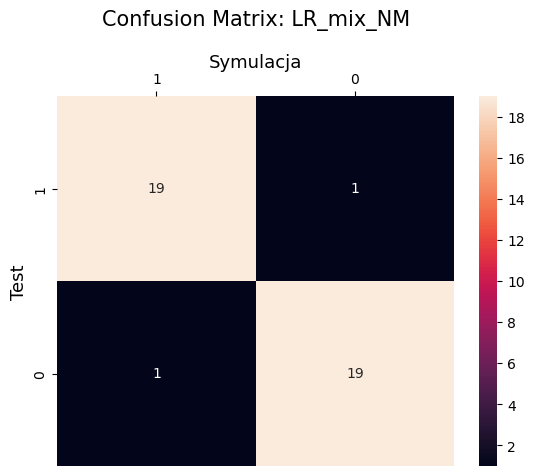

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_smote_NM
[[19  1]
 [ 1 19]]
Classification Report for LR_smote_NM
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



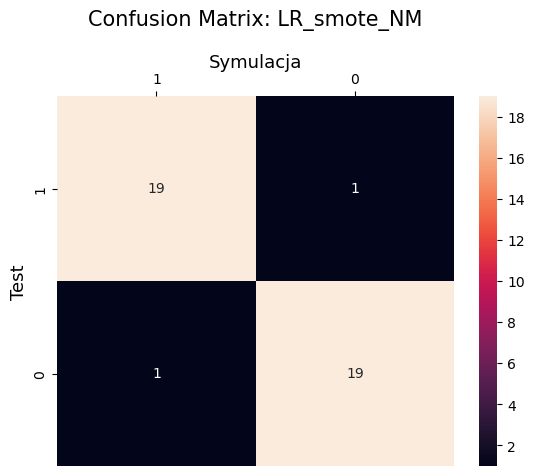

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_GAN_NM
[[20  0]
 [ 1 19]]
Classification Report for LR_GAN_NM
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



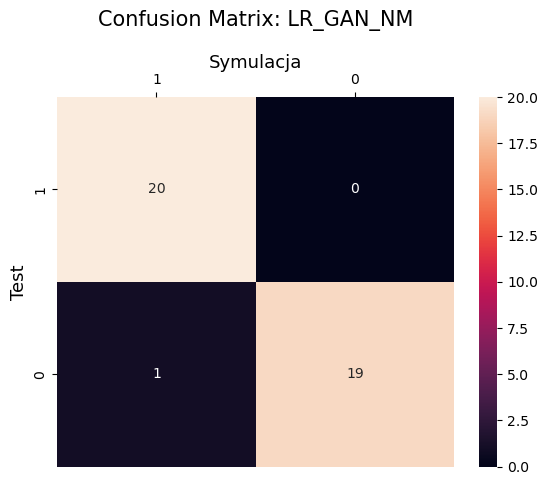

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_borderline_NM
[[19  1]
 [ 3 17]]
Classification Report for LR_borderline_NM
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.94      0.85      0.89        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



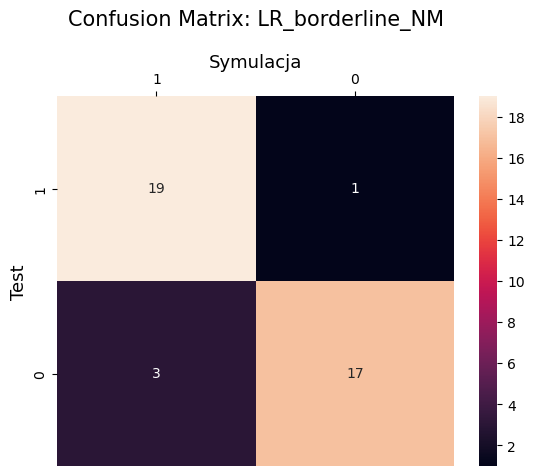

Confusion Matrix for LR_mix_KM
[[ 0 20]
 [20  0]]
Classification Report for LR_mix_KM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      20.0
           1       0.00      0.00      0.00      20.0

    accuracy                           0.00      40.0
   macro avg       0.00      0.00      0.00      40.0
weighted avg       0.00      0.00      0.00      40.0



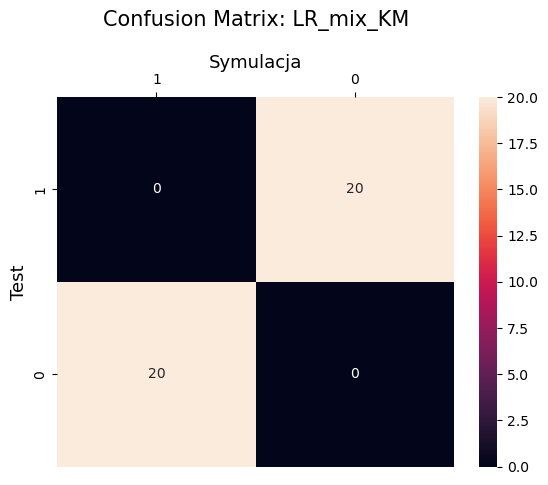

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_smote_KM
[[ 0 20]
 [20  0]]
Classification Report for LR_smote_KM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      20.0
           1       0.00      0.00      0.00      20.0

    accuracy                           0.00      40.0
   macro avg       0.00      0.00      0.00      40.0
weighted avg       0.00      0.00      0.00      40.0



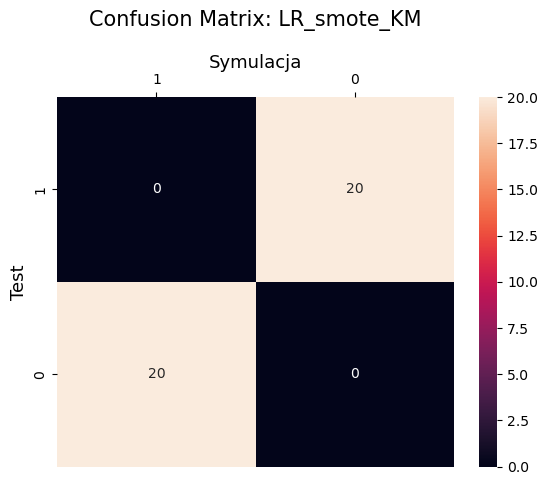

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_GAN_KM
[[ 1 19]
 [15  5]]
Classification Report for LR_GAN_KM
              precision    recall  f1-score   support

           0       0.06      0.05      0.06        20
           1       0.21      0.25      0.23        20

    accuracy                           0.15        40
   macro avg       0.14      0.15      0.14        40
weighted avg       0.14      0.15      0.14        40



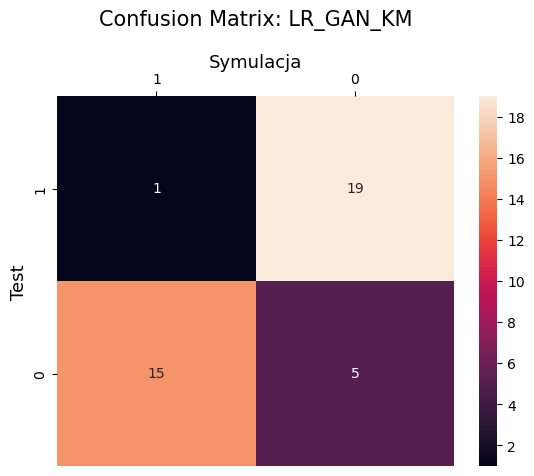

Confusion Matrix for LR_borderline_KM
[[ 1 19]
 [20  0]]
Classification Report for LR_borderline_KM
              precision    recall  f1-score   support

           0       0.05      0.05      0.05        20
           1       0.00      0.00      0.00        20

    accuracy                           0.03        40
   macro avg       0.02      0.03      0.02        40
weighted avg       0.02      0.03      0.02        40



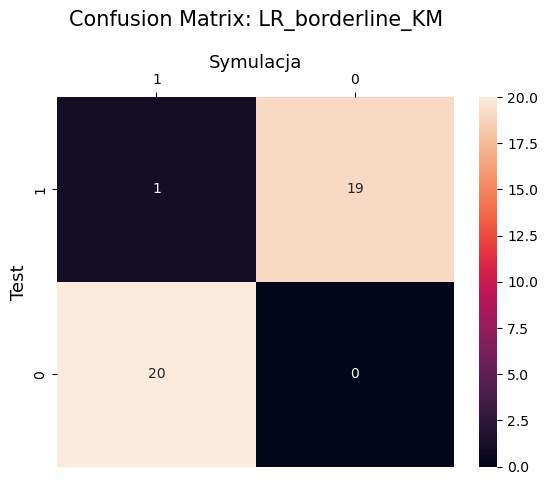

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_mix_CC
[[20  0]
 [ 1 19]]
Classification Report for LR_mix_CC
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



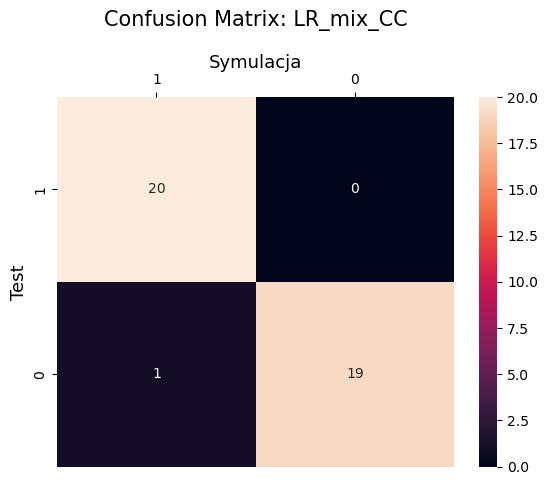

Confusion Matrix for LR_smote_CC
[[20  0]
 [ 0 20]]
Classification Report for LR_smote_CC
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



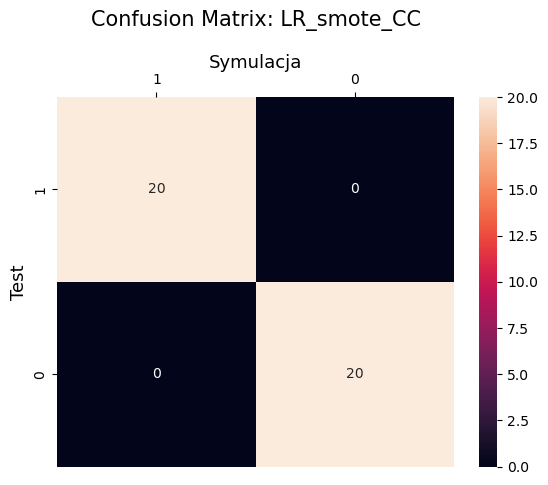

c:\Users\mateu\anaconda3\envs\python8\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LR_GAN_CC
[[20  0]
 [ 5 15]]
Classification Report for LR_GAN_CC
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        20
           1       1.00      0.75      0.86        20

    accuracy                           0.88        40
   macro avg       0.90      0.88      0.87        40
weighted avg       0.90      0.88      0.87        40



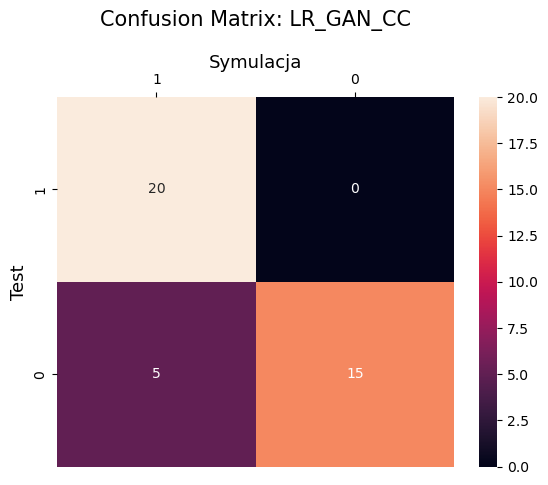

Confusion Matrix for LR_borderline_CC
[[18  2]
 [ 0 20]]
Classification Report for LR_borderline_CC
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.91      1.00      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



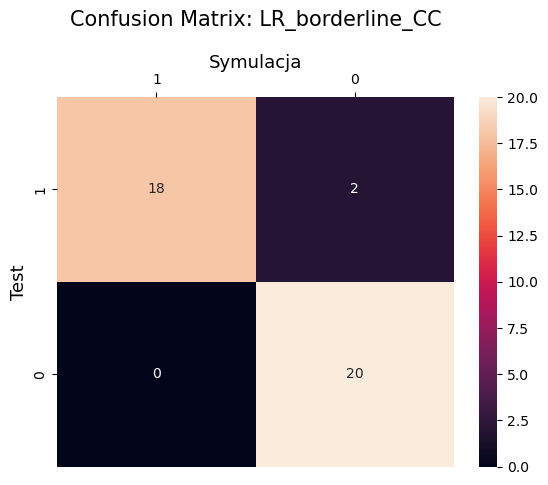

Confusion Matrix for DT_mix_NM
[[20  0]
 [ 1 19]]
Classification Report for DT_mix_NM
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



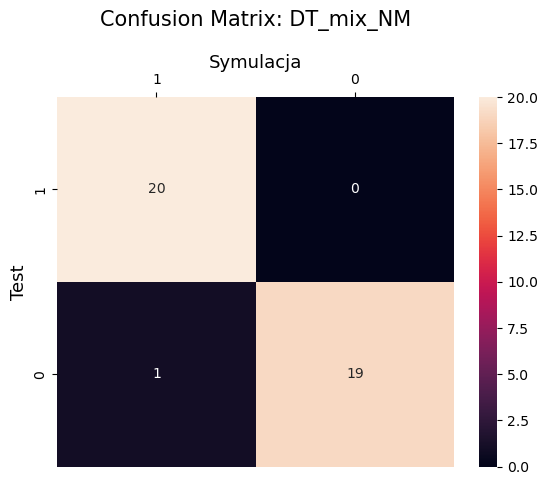

Confusion Matrix for DT_smote_NM
[[20  0]
 [ 1 19]]
Classification Report for DT_smote_NM
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



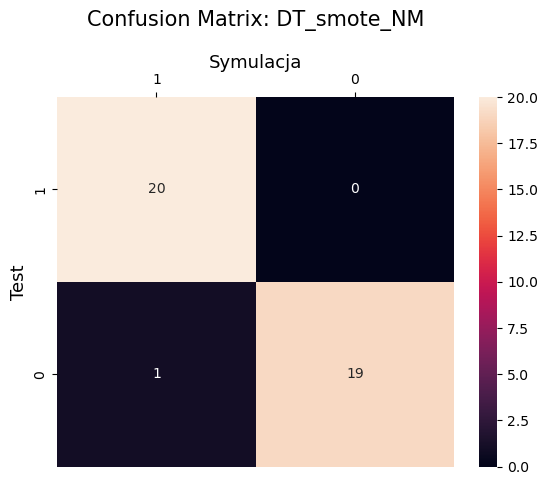

Confusion Matrix for DT_GAN_NM
[[19  1]
 [ 0 20]]
Classification Report for DT_GAN_NM
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



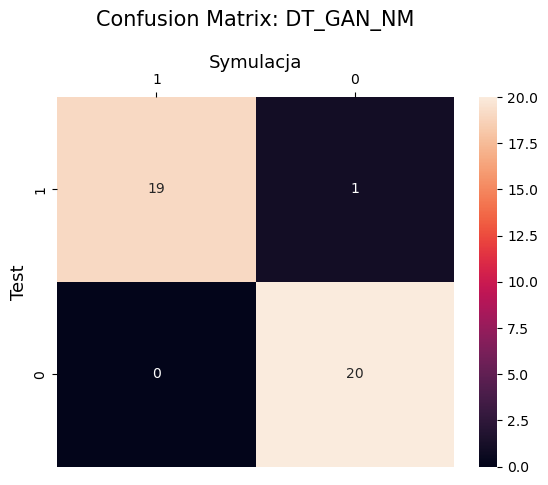

Confusion Matrix for DT_borderline_NM
[[20  0]
 [ 1 19]]
Classification Report for DT_borderline_NM
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



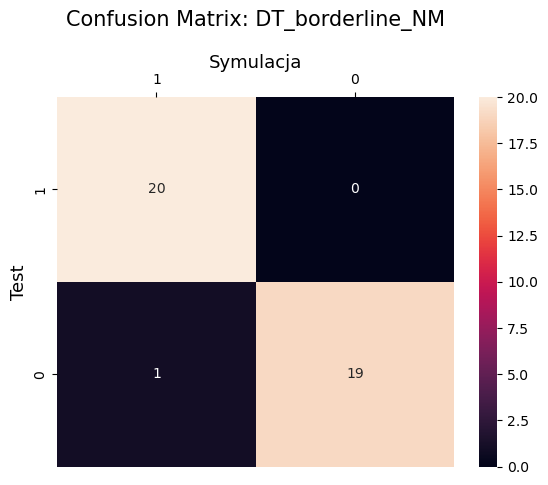

Confusion Matrix for DT_mix_KM
[[ 1 19]
 [19  1]]
Classification Report for DT_mix_KM
              precision    recall  f1-score   support

           0       0.05      0.05      0.05        20
           1       0.05      0.05      0.05        20

    accuracy                           0.05        40
   macro avg       0.05      0.05      0.05        40
weighted avg       0.05      0.05      0.05        40



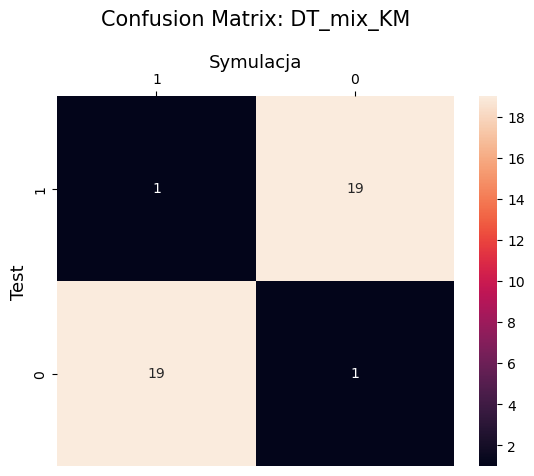

Confusion Matrix for DT_smote_KM
[[ 1 19]
 [19  1]]
Classification Report for DT_smote_KM
              precision    recall  f1-score   support

           0       0.05      0.05      0.05        20
           1       0.05      0.05      0.05        20

    accuracy                           0.05        40
   macro avg       0.05      0.05      0.05        40
weighted avg       0.05      0.05      0.05        40



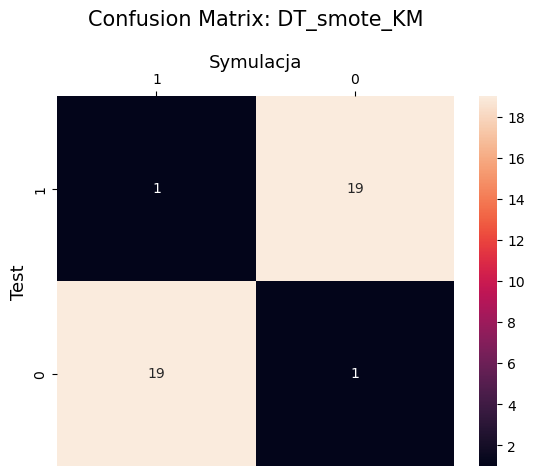

Confusion Matrix for DT_GAN_KM
[[ 1 19]
 [19  1]]
Classification Report for DT_GAN_KM
              precision    recall  f1-score   support

           0       0.05      0.05      0.05        20
           1       0.05      0.05      0.05        20

    accuracy                           0.05        40
   macro avg       0.05      0.05      0.05        40
weighted avg       0.05      0.05      0.05        40



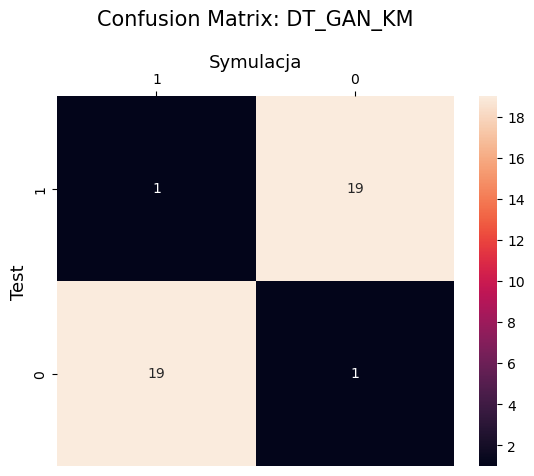

Confusion Matrix for DT_borderline_KM
[[ 1 19]
 [19  1]]
Classification Report for DT_borderline_KM
              precision    recall  f1-score   support

           0       0.05      0.05      0.05        20
           1       0.05      0.05      0.05        20

    accuracy                           0.05        40
   macro avg       0.05      0.05      0.05        40
weighted avg       0.05      0.05      0.05        40



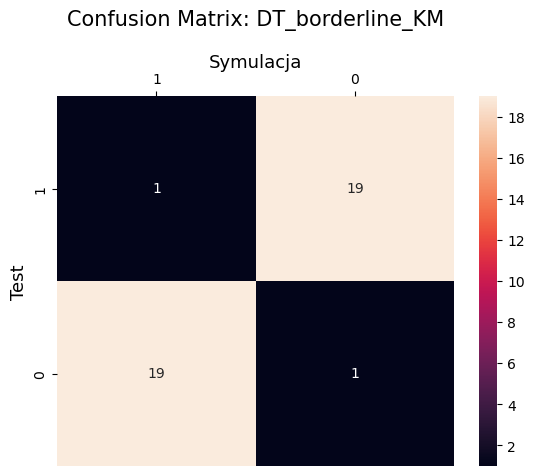

Confusion Matrix for DT_mix_CC
[[19  1]
 [ 1 19]]
Classification Report for DT_mix_CC
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



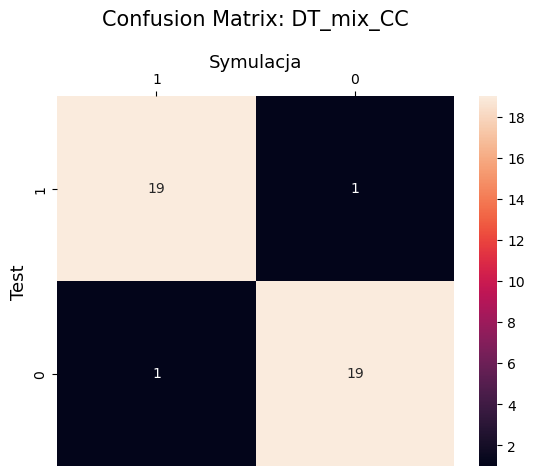

Confusion Matrix for DT_smote_CC
[[19  1]
 [ 1 19]]
Classification Report for DT_smote_CC
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



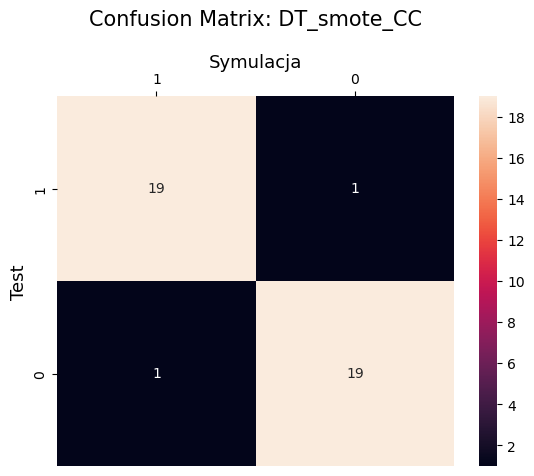

Confusion Matrix for DT_GAN_CC
[[19  1]
 [13  7]]
Classification Report for DT_GAN_CC
              precision    recall  f1-score   support

           0       0.59      0.95      0.73        20
           1       0.88      0.35      0.50        20

    accuracy                           0.65        40
   macro avg       0.73      0.65      0.62        40
weighted avg       0.73      0.65      0.62        40



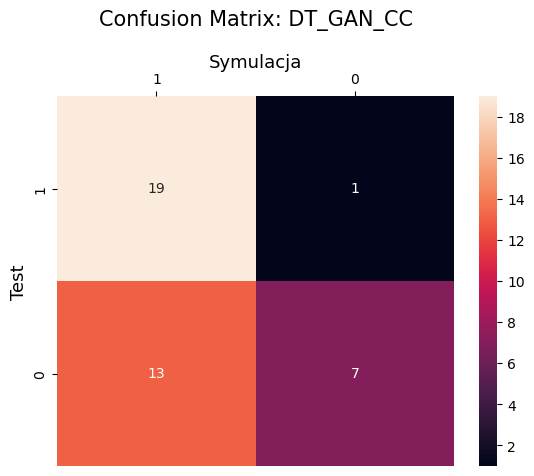

Confusion Matrix for DT_borderline_CC
[[20  0]
 [ 1 19]]
Classification Report for DT_borderline_CC
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



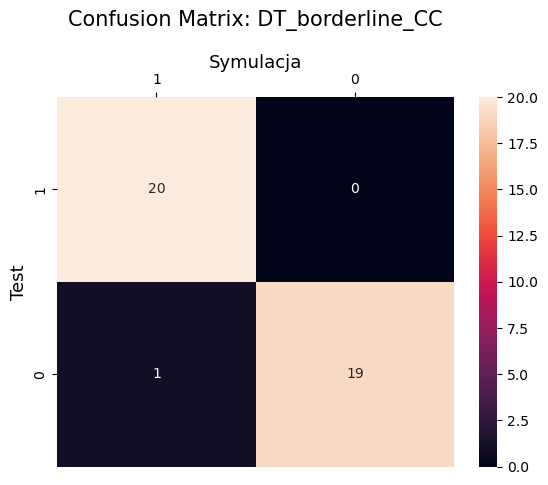

Confusion Matrix for RF_mix_NM
[[20  0]
 [ 0 20]]
Classification Report for RF_mix_NM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



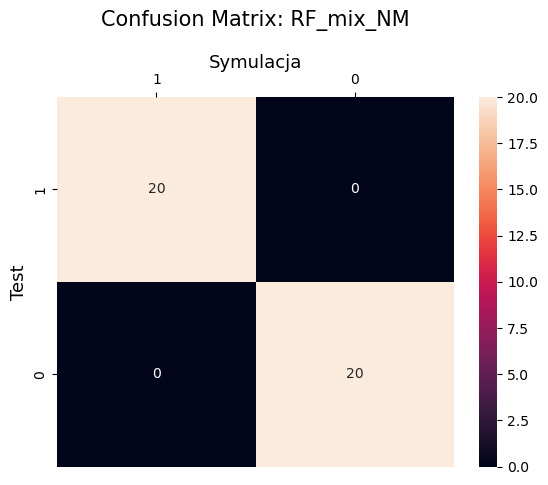

Confusion Matrix for RF_smote_NM
[[19  1]
 [ 0 20]]
Classification Report for RF_smote_NM
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



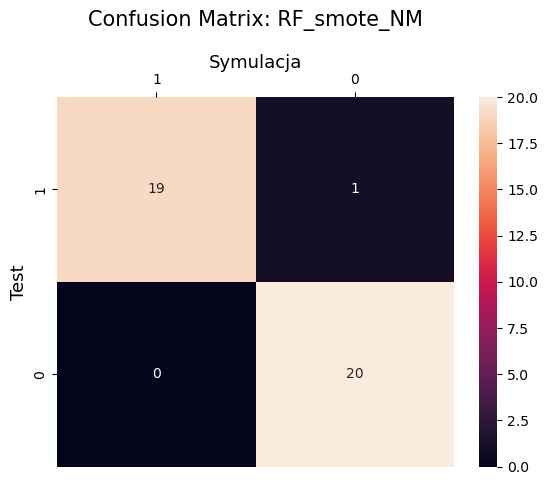

Confusion Matrix for RF_GAN_NM
[[19  1]
 [ 0 20]]
Classification Report for RF_GAN_NM
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



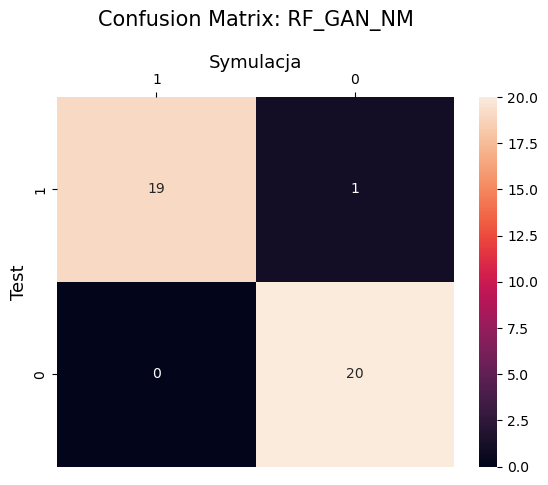

Confusion Matrix for RF_borderline_NM
[[19  1]
 [ 1 19]]
Classification Report for RF_borderline_NM
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



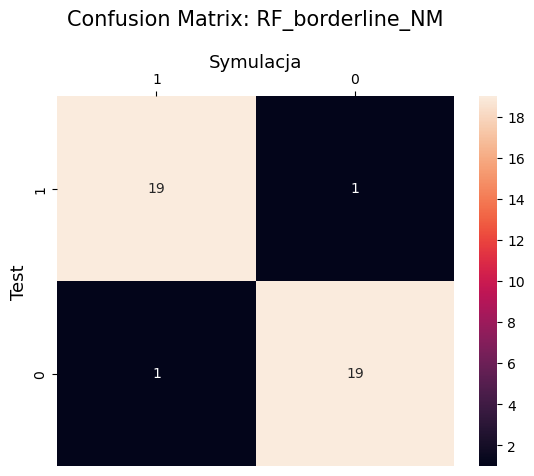

Confusion Matrix for RF_mix_KM
[[ 0 20]
 [20  0]]
Classification Report for RF_mix_KM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      20.0
           1       0.00      0.00      0.00      20.0

    accuracy                           0.00      40.0
   macro avg       0.00      0.00      0.00      40.0
weighted avg       0.00      0.00      0.00      40.0



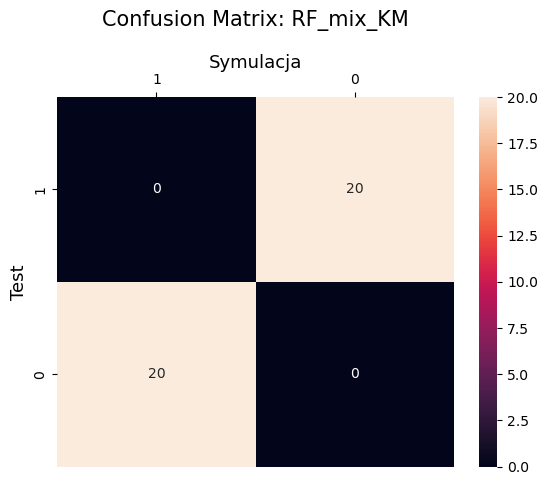

Confusion Matrix for RF_smote_KM
[[ 0 20]
 [20  0]]
Classification Report for RF_smote_KM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      20.0
           1       0.00      0.00      0.00      20.0

    accuracy                           0.00      40.0
   macro avg       0.00      0.00      0.00      40.0
weighted avg       0.00      0.00      0.00      40.0



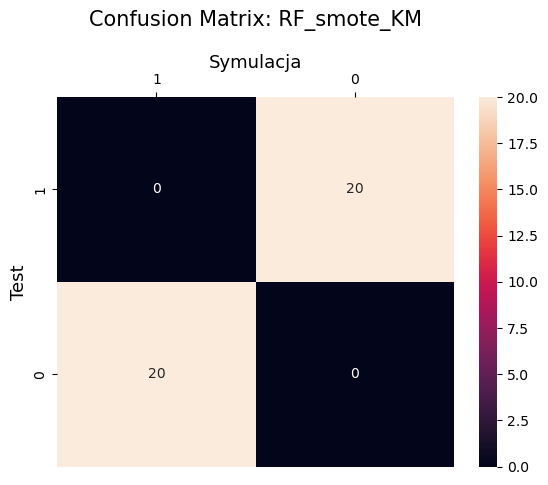

Confusion Matrix for RF_GAN_KM
[[ 0 20]
 [11  9]]
Classification Report for RF_GAN_KM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.31      0.45      0.37        20

    accuracy                           0.23        40
   macro avg       0.16      0.23      0.18        40
weighted avg       0.16      0.23      0.18        40



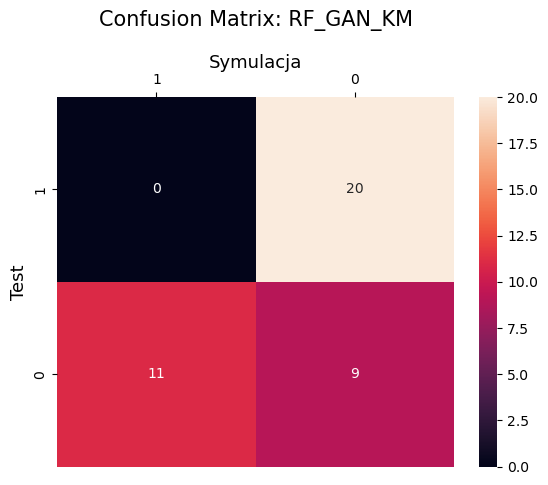

Confusion Matrix for RF_borderline_KM
[[ 0 20]
 [20  0]]
Classification Report for RF_borderline_KM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      20.0
           1       0.00      0.00      0.00      20.0

    accuracy                           0.00      40.0
   macro avg       0.00      0.00      0.00      40.0
weighted avg       0.00      0.00      0.00      40.0



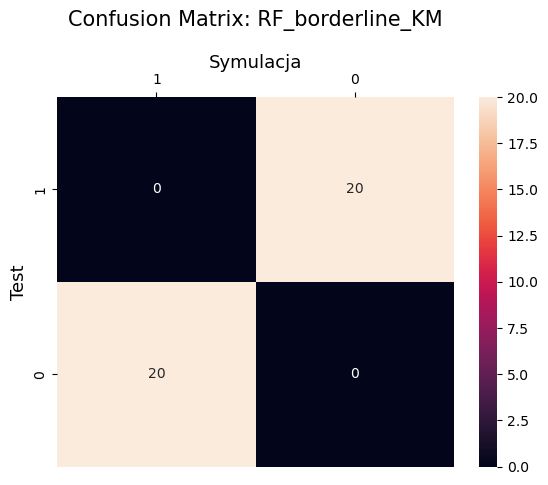

Confusion Matrix for RF_mix_CC
[[20  0]
 [ 2 18]]
Classification Report for RF_mix_CC
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.90      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



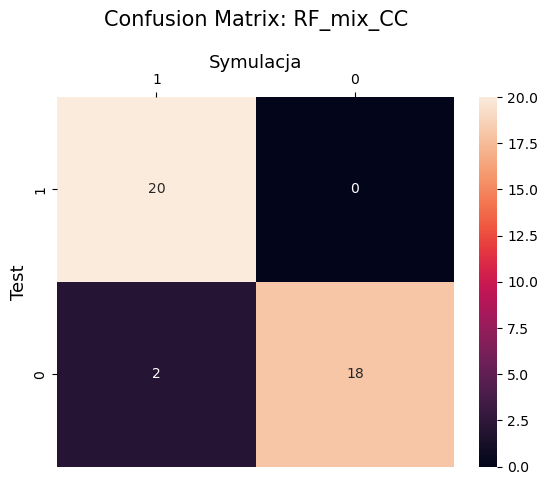

Confusion Matrix for RF_smote_CC
[[20  0]
 [ 0 20]]
Classification Report for RF_smote_CC
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



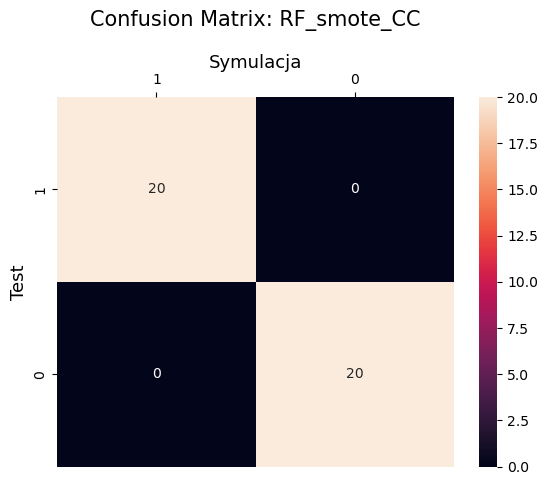

Confusion Matrix for RF_GAN_CC
[[19  1]
 [ 3 17]]
Classification Report for RF_GAN_CC
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.94      0.85      0.89        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



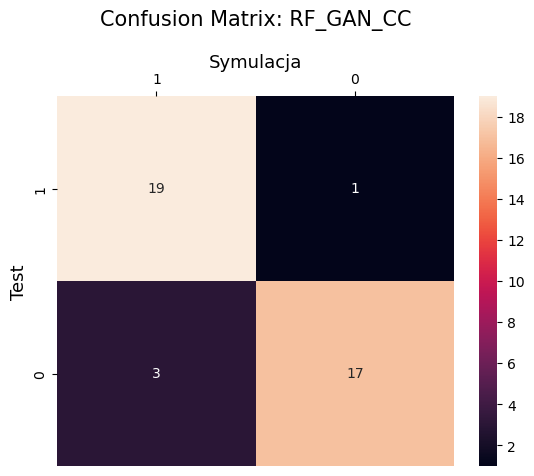

Confusion Matrix for RF_borderline_CC
[[20  0]
 [ 0 20]]
Classification Report for RF_borderline_CC
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



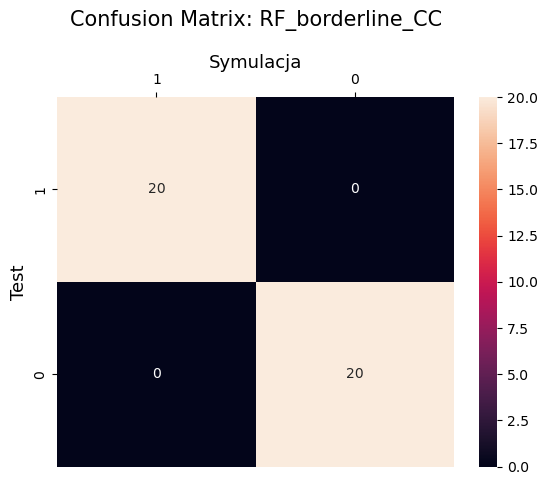

Confusion Matrix for XGB_mix_NM
[[20  0]
 [ 0 20]]
Classification Report for XGB_mix_NM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



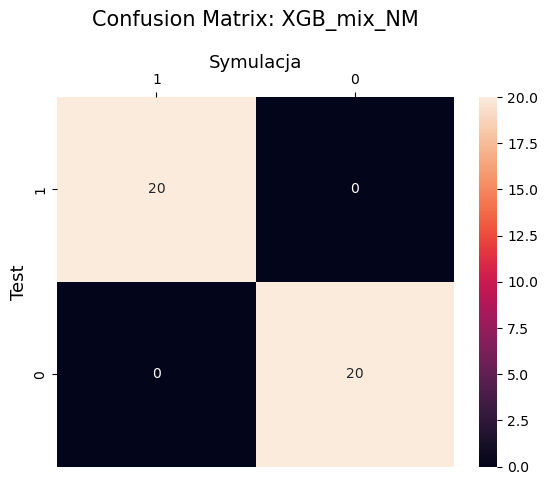

Confusion Matrix for XGB_smote_NM
[[20  0]
 [ 0 20]]
Classification Report for XGB_smote_NM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



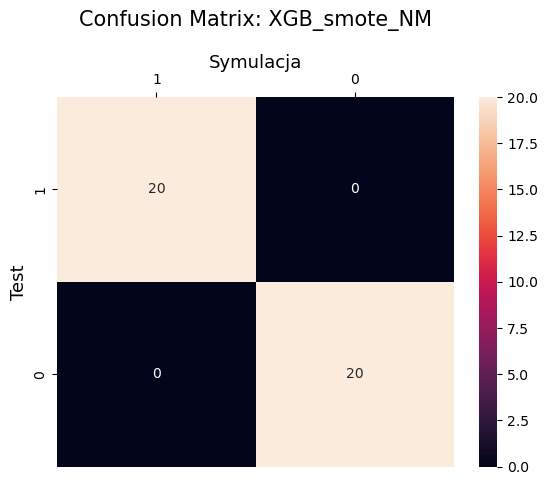

Confusion Matrix for XGB_GAN_NM
[[20  0]
 [ 0 20]]
Classification Report for XGB_GAN_NM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



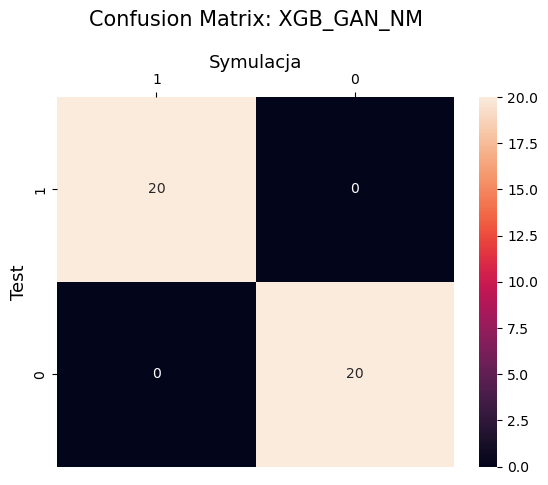

Confusion Matrix for XGB_borderline_NM
[[20  0]
 [ 0 20]]
Classification Report for XGB_borderline_NM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



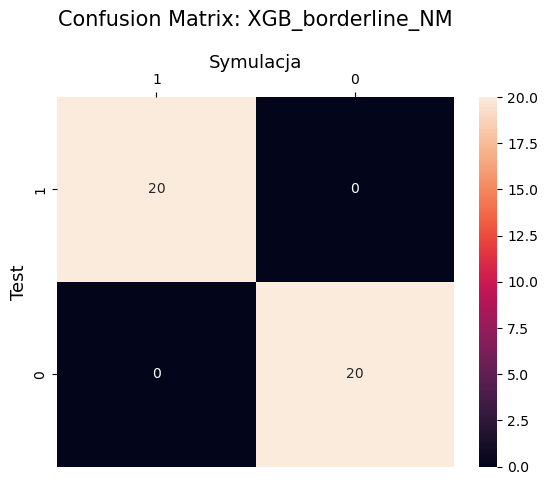

Confusion Matrix for XGB_mix_KM
[[ 1 19]
 [20  0]]
Classification Report for XGB_mix_KM
              precision    recall  f1-score   support

           0       0.05      0.05      0.05        20
           1       0.00      0.00      0.00        20

    accuracy                           0.03        40
   macro avg       0.02      0.03      0.02        40
weighted avg       0.02      0.03      0.02        40



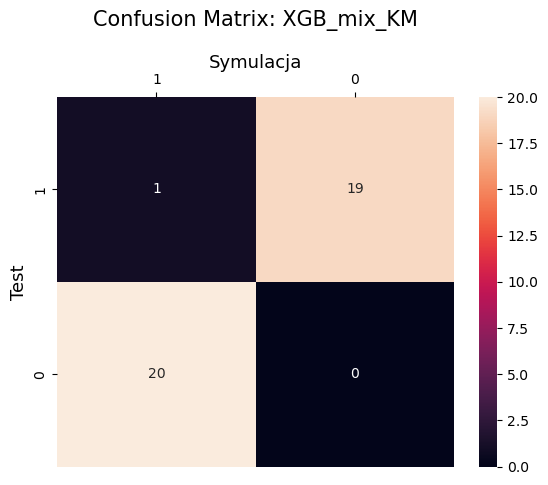

Confusion Matrix for XGB_smote_KM
[[ 0 20]
 [20  0]]
Classification Report for XGB_smote_KM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      20.0
           1       0.00      0.00      0.00      20.0

    accuracy                           0.00      40.0
   macro avg       0.00      0.00      0.00      40.0
weighted avg       0.00      0.00      0.00      40.0



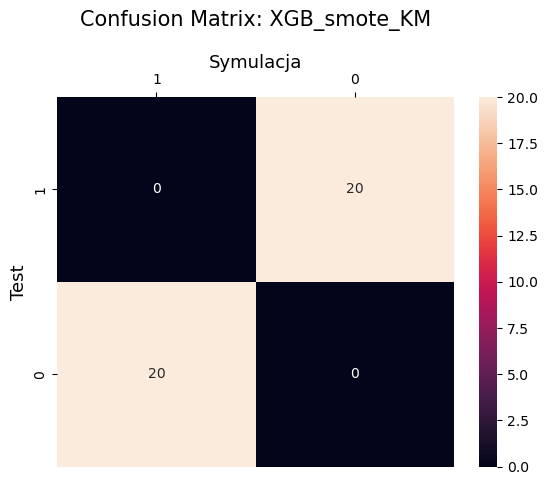

Confusion Matrix for XGB_GAN_KM
[[ 1 19]
 [14  6]]
Classification Report for XGB_GAN_KM
              precision    recall  f1-score   support

           0       0.07      0.05      0.06        20
           1       0.24      0.30      0.27        20

    accuracy                           0.17        40
   macro avg       0.15      0.17      0.16        40
weighted avg       0.15      0.17      0.16        40



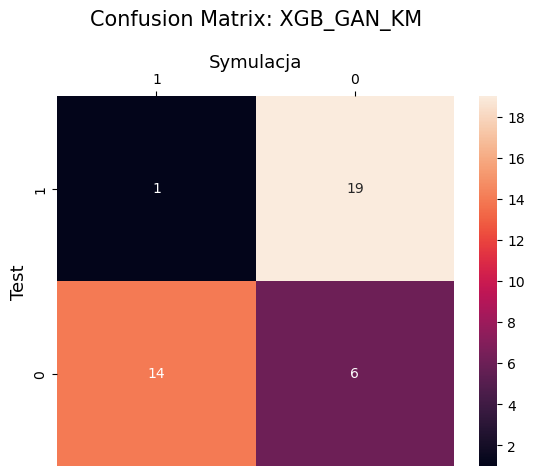

Confusion Matrix for XGB_borderline_KM
[[ 0 20]
 [20  0]]
Classification Report for XGB_borderline_KM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      20.0
           1       0.00      0.00      0.00      20.0

    accuracy                           0.00      40.0
   macro avg       0.00      0.00      0.00      40.0
weighted avg       0.00      0.00      0.00      40.0



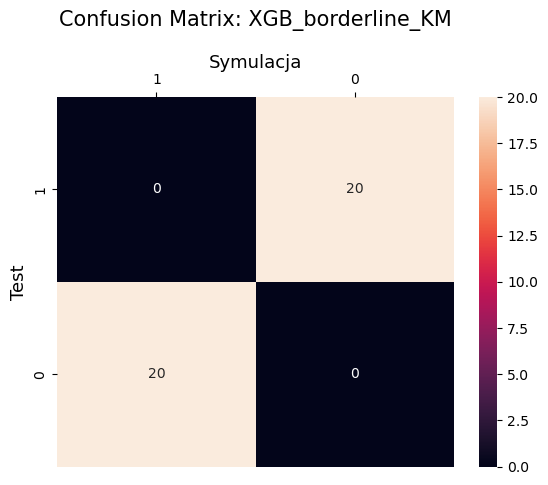

Confusion Matrix for XGB_mix_CC
[[19  1]
 [ 3 17]]
Classification Report for XGB_mix_CC
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.94      0.85      0.89        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



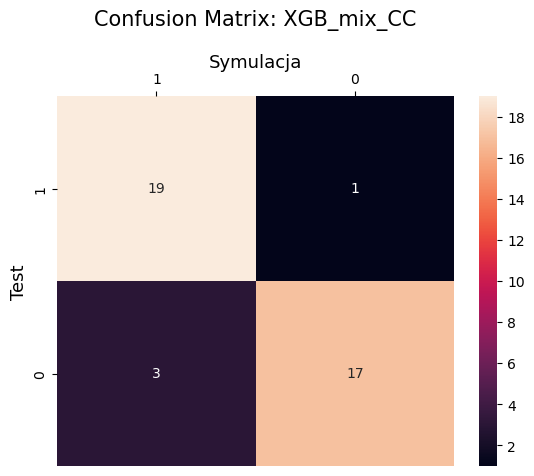

Confusion Matrix for XGB_smote_CC
[[20  0]
 [ 0 20]]
Classification Report for XGB_smote_CC
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



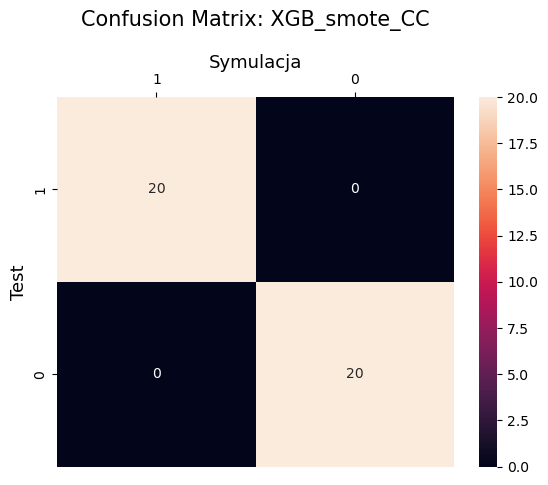

Confusion Matrix for XGB_GAN_CC
[[19  1]
 [ 3 17]]
Classification Report for XGB_GAN_CC
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.94      0.85      0.89        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



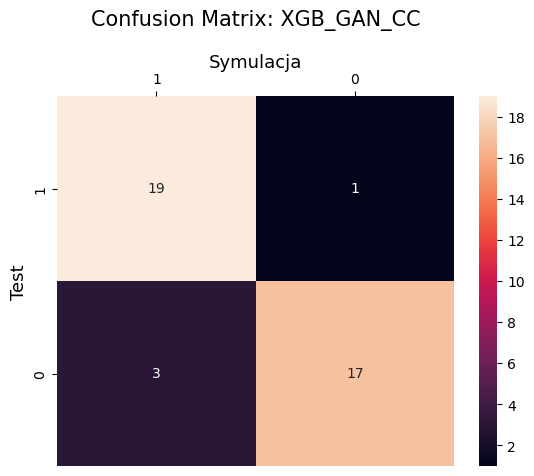

Confusion Matrix for XGB_borderline_CC
[[19  1]
 [ 0 20]]
Classification Report for XGB_borderline_CC
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



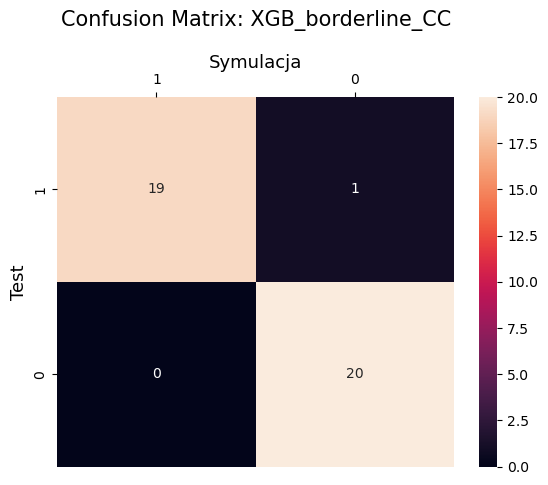

Confusion Matrix for XGBRF_mix_NM
[[19  1]
 [ 0 20]]
Classification Report for XGBRF_mix_NM
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



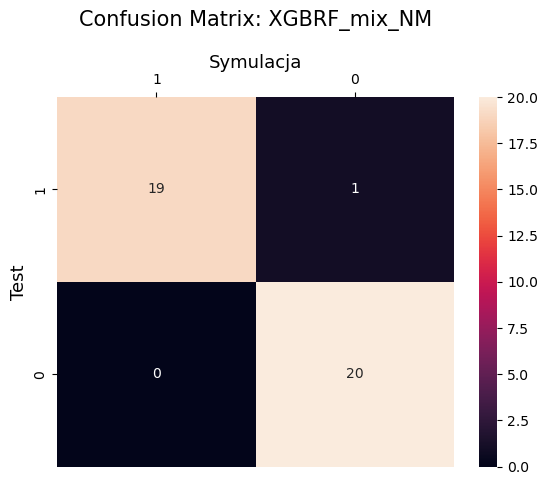

Confusion Matrix for XGBRF_smote_NM
[[19  1]
 [ 0 20]]
Classification Report for XGBRF_smote_NM
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



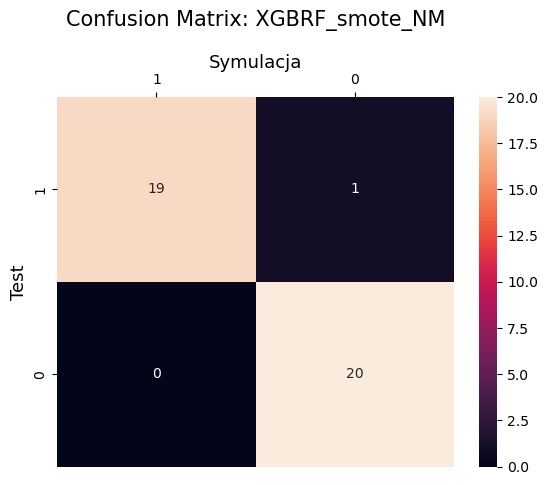

Confusion Matrix for XGBRF_GAN_NM
[[18  2]
 [ 0 20]]
Classification Report for XGBRF_GAN_NM
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.91      1.00      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



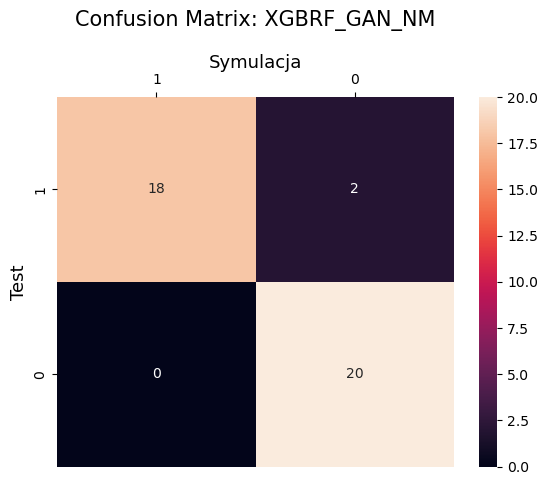

Confusion Matrix for XGBRF_borderline_NM
[[19  1]
 [ 0 20]]
Classification Report for XGBRF_borderline_NM
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



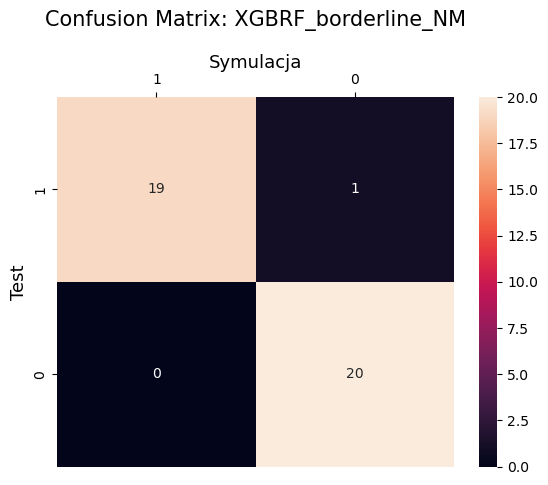

Confusion Matrix for XGBRF_mix_KM
[[ 1 19]
 [20  0]]
Classification Report for XGBRF_mix_KM
              precision    recall  f1-score   support

           0       0.05      0.05      0.05        20
           1       0.00      0.00      0.00        20

    accuracy                           0.03        40
   macro avg       0.02      0.03      0.02        40
weighted avg       0.02      0.03      0.02        40



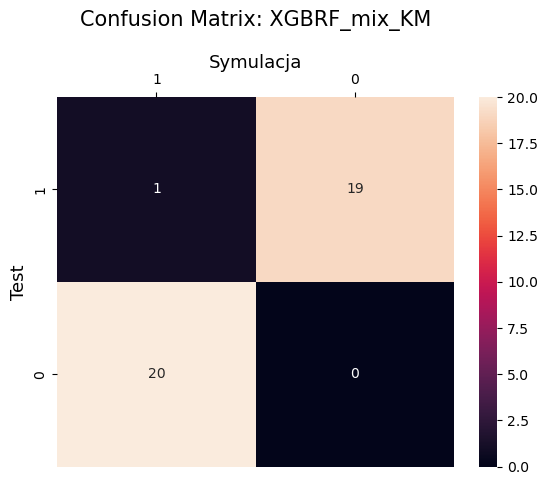

Confusion Matrix for XGBRF_smote_KM
[[ 1 19]
 [20  0]]
Classification Report for XGBRF_smote_KM
              precision    recall  f1-score   support

           0       0.05      0.05      0.05        20
           1       0.00      0.00      0.00        20

    accuracy                           0.03        40
   macro avg       0.02      0.03      0.02        40
weighted avg       0.02      0.03      0.02        40



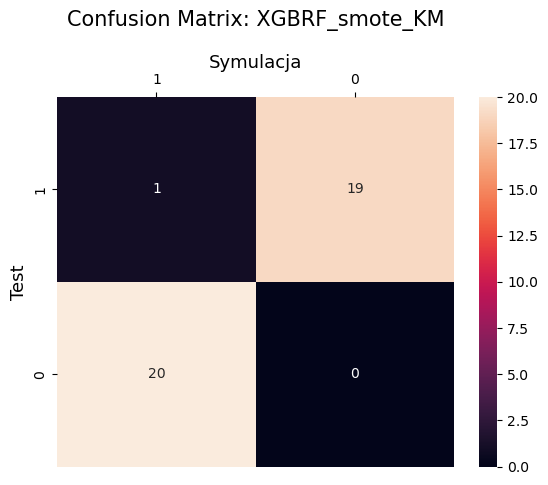

Confusion Matrix for XGBRF_GAN_KM
[[ 1 19]
 [16  4]]
Classification Report for XGBRF_GAN_KM
              precision    recall  f1-score   support

           0       0.06      0.05      0.05        20
           1       0.17      0.20      0.19        20

    accuracy                           0.12        40
   macro avg       0.12      0.12      0.12        40
weighted avg       0.12      0.12      0.12        40



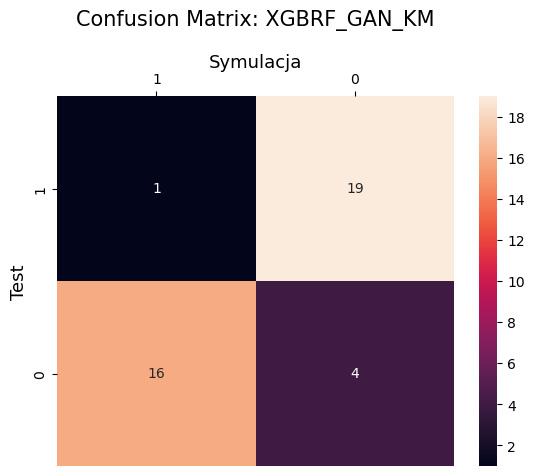

Confusion Matrix for XGBRF_borderline_KM
[[ 1 19]
 [20  0]]
Classification Report for XGBRF_borderline_KM
              precision    recall  f1-score   support

           0       0.05      0.05      0.05        20
           1       0.00      0.00      0.00        20

    accuracy                           0.03        40
   macro avg       0.02      0.03      0.02        40
weighted avg       0.02      0.03      0.02        40



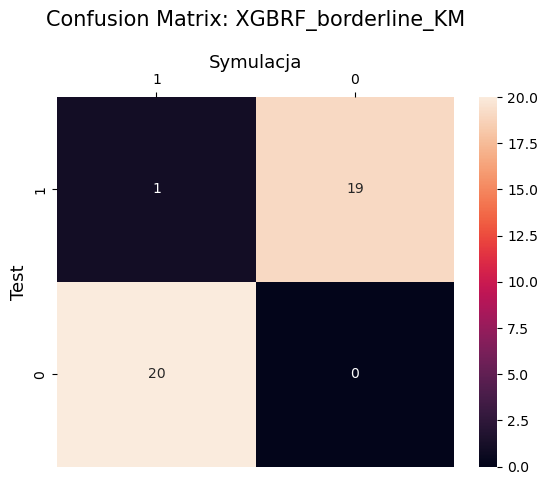

Confusion Matrix for XGBRF_mix_CC
[[18  2]
 [ 0 20]]
Classification Report for XGBRF_mix_CC
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.91      1.00      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



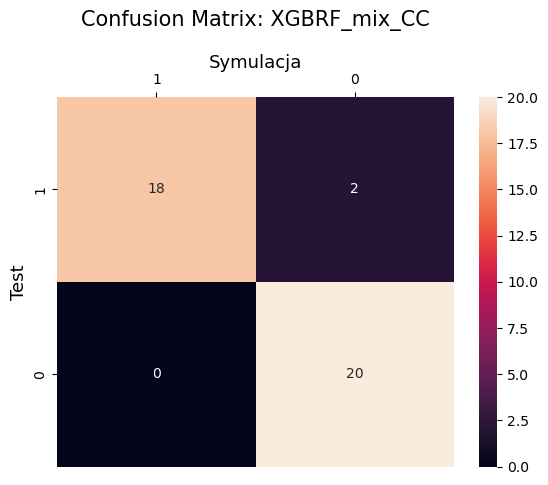

Confusion Matrix for XGBRF_smote_CC
[[19  1]
 [ 0 20]]
Classification Report for XGBRF_smote_CC
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



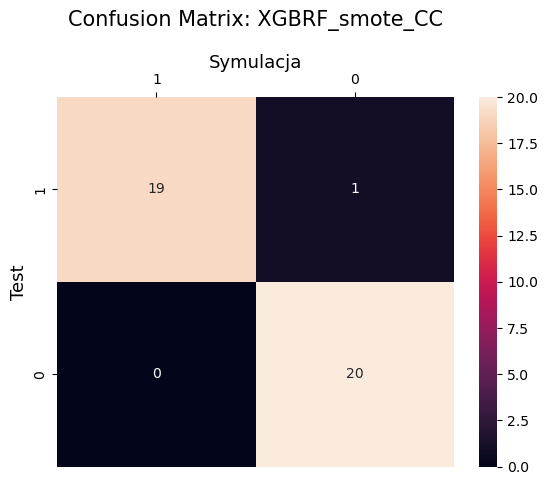

Confusion Matrix for XGBRF_GAN_CC
[[19  1]
 [ 1 19]]
Classification Report for XGBRF_GAN_CC
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



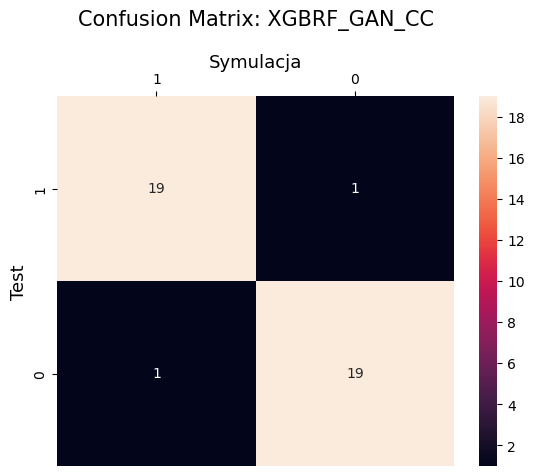

Confusion Matrix for XGBRF_borderline_CC
[[19  1]
 [ 0 20]]
Classification Report for XGBRF_borderline_CC
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



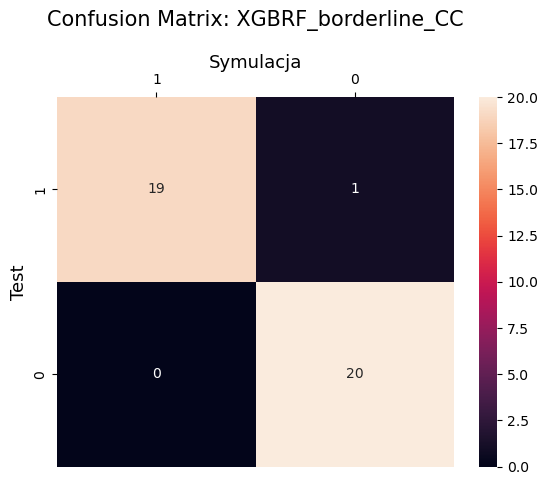

In [49]:



# generate reports + confusion matrix
for model_key, data_key in zip(models.keys(), training_data.keys()):
    X_train, y_train = training_data[data_key]
    
        # Load the best model using pickle
    model_filename = f"D:\\ml\\undersampling_data\\models\\ssh\\{model_key}.joblib"
    with open(model_filename, 'rb') as model_file:
        best_model = load(model_file)
        
        best_model.fit(X_train, y_train)
        # Predict using the best model
        y_pred = best_model.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix for {model_key}")
        print(cm)

        cr = classification_report(y_test, y_pred)
        print(f"Classification Report for {model_key}")
        print(cr)
        
        cf = "D:\\ml\\undersampling_data\\reports\\ssh\\results\\confusion_matrix.txt"
        with open(cf, "a+") as f:
            # Zapis wyników do pliku
            print(f"Confusion Matrix for {model_key}", file=f)
            print(cm, file=f)
            print(f"Classification Report for {model_key}", file=f)
            print(cr, file=f)
        
        #make a heatmap
        sns.heatmap(cm, annot=True, xticklabels=["1", "0"], yticklabels=["1", "0"])
        plt.ylabel("Test", fontsize=13)
        plt.title(f"Confusion Matrix: {model_key}", fontsize=15, pad=20)
        plt.gca().xaxis.set_label_position("top")
        plt.xlabel("Symulacja", fontsize=13)
        plt.gca().xaxis.tick_top()
        plt.savefig(f'D:\\ml\\undersampling_data\\reports\\ssh\\results\\figures\\{model_key}.png', bbox_inches="tight", dpi=200)     
        plt.show()
        plt.close()  